In [5]:
import numpy as np
import imutils
import pickle
import cv2
import os
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import datetime

In [6]:
# Load models and utilities
def load_face_detector(proto_path, model_path):
    """Load the face detector model."""
    print("Loading Face Detector...")
    return cv2.dnn.readNetFromCaffe(proto_path, model_path)

def load_face_embedder(model_path):
    """Load the face embedding model."""
    print("Loading Face Recognizer...")
    return cv2.dnn.readNetFromTorch(model_path)

def load_recognizer_and_label_encoder(recognizer_path, le_path):
    """Load the face recognition model and label encoder."""
    with open(recognizer_path, "rb") as f:
        recognizer = pickle.load(f)
    with open(le_path, "rb") as f:
        le = pickle.load(f)
    return recognizer, le

In [8]:
proto_path = "C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\face_detection_model\\deploy.prototxt"
proto_path

'C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\face_detection_model\\deploy.prototxt'

In [9]:
model_path = "C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\face_detection_model\\res10_300x300_ssd_iter_140000.caffemodel"
model_path

'C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\face_detection_model\\res10_300x300_ssd_iter_140000.caffemodel'

In [10]:
detector = load_face_detector(proto_path, model_path)
detector

Loading Face Detector...


< cv2.dnn.Net 0000013853023030>

In [11]:
embedder = load_face_embedder('C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\face_detection_model\\openface_nn4.small2.v1.t7')
recognizer, le = load_recognizer_and_label_encoder('C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\embeddings.pickle', 'C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\le.pickle')

Loading Face Recognizer...


In [ ]:
recognizer.keys() 

dict_keys(['embeddings', 'names'])

In [ ]:
import cv2
import os
import time

def create_user_dataset(username, num_images=10):
    dataset_path = os.path.join("dataset", username)
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    # Start video capture (webcam)
    cap = cv2.VideoCapture(0)

    # Set properties to improve image quality
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    cap.set(cv2.CAP_PROP_FPS, 30)

    # Initialize counter for the number of images captured
    count = 0

    print(f"[INFO] Starting to capture images for user: {username}")
    while count < num_images:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("[ERROR] Failed to capture image from webcam.")
            break

        # Allow more time for better image quality
        time.sleep(0.1)

        # Display the resulting frame
        cv2.imshow('Capture Images (Press "q" to quit)', frame)
        # Save the current frame as an image file
        image_path = os.path.join(dataset_path, f"{str(count).zfill(5)}.png")
        cv2.imwrite(image_path, frame)
        count += 1

        print(f"[INFO] Captured image {count}/{num_images}")

        # Press 'q' to quit capturing images early
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()
    print(f"[INFO] Completed capturing {count} images for user: {username}")

create_user_dataset("dung")


[INFO] Starting to capture images for user: dung
[INFO] Captured image 1/10
[INFO] Captured image 2/10
[INFO] Captured image 3/10
[INFO] Captured image 4/10
[INFO] Captured image 5/10
[INFO] Captured image 6/10
[INFO] Captured image 7/10
[INFO] Captured image 8/10
[INFO] Captured image 9/10
[INFO] Captured image 10/10
[INFO] Completed capturing 10 images for user: dung


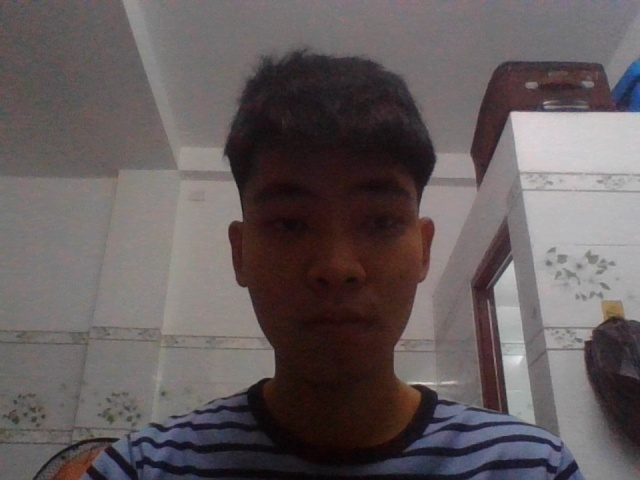

Stopped.


In [ ]:
import cv2
import numpy as np
from IPython.display import display, clear_output,Image
from time import sleep
import pickle


# Load the face detector
def load_face_detector(proto_path, model_path):
    return cv2.dnn.readNetFromCaffe(proto_path, model_path)

# Load the face embedder
def load_face_embedder(embedder_path):
    return cv2.dnn.readNetFromTorch(embedder_path)

# Load recognizer and label encoder
def load_recognizer_and_label_encoder(recognizer_path, le_path):
    recognizer = pickle.load(open(recognizer_path, "rb"))
    le = pickle.load(open(le_path, "rb"))
    return recognizer, le

# Load the models
proto_path = "C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\face_detection_model\\deploy.prototxt"
model_path = "C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\face_detection_model\\res10_300x300_ssd_iter_140000.caffemodel"
embedder_path = "C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\face_detection_model\\openface_nn4.small2.v1.t7"
recognizer_path = "C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\embeddings.pickle"
le_path = "C:\\Users\\tdun\\Documents\\QuanLyNhanSu\\face-recognition-using-opencv\\model\\le.pickle"

detector = load_face_detector(proto_path, model_path)
embedder = load_face_embedder(embedder_path)
recognizer, le = load_recognizer_and_label_encoder(recognizer_path, le_path)

# Real-time face detection
def realtime_face_detection():
    cap = cv2.VideoCapture(0)
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break
            
            h, w = frame.shape[:2]
            blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
            detector.setInput(blob)
            detections = detector.forward()
            
            # Loop over detections
            for i in range(0, detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > 0.5:  # Confidence threshold
                    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                    (startX, startY, endX, endY) = box.astype("int")
                    
                    # Draw bounding box
                    text = f"{confidence * 100:.2f}%"
                    
                    y = startY - 10 if startY - 10 > 10 else startY + 10
                    cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
                    cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
            
            # Display in Jupyter Notebook
            clear_output(wait=True)
            _, jpeg = cv2.imencode('.jpg', frame)
            display(Image(data=jpeg.tobytes()))
            display(frame.shape)
            sleep(0.1)
    except KeyboardInterrupt:
        print("Stopped.")
    finally:
        cap.release()
        cv2.destroyAllWindows()

realtime_face_detection()


In [ ]:
print(type(recognizer))


<class 'dict'>


In [27]:
def recognize_faces(image, faces, embedder, recognizer, le, attendance_list):
    """Recognize faces in the image and draw the results."""
    for (face, (startX, startY, endX, endY)) in faces:
        (fH, fW) = face.shape[:2]

        # Ensure the face width and height are sufficiently large
        if fW < 20 or fH < 20:
            continue

        # Construct a blob for the face ROI
        face_blob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
                                          (0, 0, 0), swapRB=True, crop=False)
        embedder.setInput(face_blob)
        vec = embedder.forward()

        # Perform classification to recognize the face
        preds = recognizer.predict_proba(vec)[0]
        j = np.argmax(preds)
        proba = preds[j]
        name = le.classes_[j]

        # Draw the bounding box of the face along with the associated probability
        text = "{}: {:.2f}%".format(name, proba * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
        cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    return image

In [28]:
def detect_faces(image, detector, min_confidence=0.5):
    """Detect faces in an image."""
    (h, w) = image.shape[:2]
    image_blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),
                                       (104.0, 177.0, 123.0), swapRB=False, crop=False)
    detector.setInput(image_blob)
    detections = detector.forward()

    faces = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # Filter out weak detections
        if confidence > min_confidence:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Ensure bounding box is within image dimensions
            startX, startY = max(0, startX), max(0, startY)
            endX, endY = min(w, endX), min(h, endY)

            face = image[startY:endY, startX:endX]
            faces.append((face, (startX, startY, endX, endY)))

    return faces

In [32]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()

In [33]:
attendance_list = {}

# Detect faces in the frame
faces = detect_faces(frame, detector)

# Recognize faces in the frame
output_frame = recognize_faces(frame, faces, embedder, recognizer, le, attendance_list)

# Display the resulting frame
cv2.imshow('Real-Time Face Recognition', output_frame)